# Data Analysis

In this notebook we will perform some basic data exploration to gain possibly useful insights on our datasets.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import warnings

### Merge Datasets

This section loads and merges the Sumerian tablet datasets from train/validation/test splits, combining the transliteration data with the English translation data using the tablet ID as a key. It creates a comprehensive dataset with both the Sumerian text and its English translation.

In [5]:
translation_train = pd.read_csv('../datasets/SumTablets_English_train.csv')
translation_val = pd.read_csv('../datasets/SumTablets_English_validation.csv')
translation_test = pd.read_csv('../datasets/SumTablets_English_test.csv')

sumTablets_train = pd.read_csv('../datasets/SumTablets_train.csv')
sumTablets_val = pd.read_csv('../datasets/SumTablets_validation.csv')
sumTablets_test = pd.read_csv('../datasets/SumTablets_test.csv')

In [6]:
display(translation_train.head())
display(sumTablets_train)

,id,period,genre,transliteration,translation
0,P459080,Ur III,Administrative,\n1(u) la₂ 1(diš) udu\nu₄ 2(u) 8(diš)-kam\nki ...,"9 rams,\n28th day,\nfrom Abba-saga,\nNalu acce..."
1,P459081,Ur III,Administrative,\n3(diš) 1/2(diš) gin₂ 1(u) 5(diš) še ku₃-babb...,"3 1/2 shekels 15 grains of silver,\nfor intere..."
2,P459082,Ur III,Administrative,\n6(diš) murgu₂ peš\n2(geš₂) 4(u) 5(diš) {geš}...,"6 date palm spines,\n165 boat ribs(?),\n6 pine..."
3,P459083,Ur III,Administrative,\n1/3(diš) kuš gu₄\n1(diš) sa gu₄\n2(diš) kuš ...,"1/3 oxen hide,\n1 (bundle of) oxen sinews,\n2 ..."
4,P459084,Ur III,Letter,\nda-da\nu₃-na-a-du₁₁\n3(gešʾu) sa gi <unk>\ng...,"To Dada,\nsay:\n“1800 bundles of fire-reeds,\n..."


,id,period,genre,transliteration,glyph_names,glyphs
0,P119622,Ur III,Administrative,<SURFACE>\n2(u) udu\nki nin-še₃\nki uš-mu-ta\n...,<SURFACE> \n |U.U| LU \n KI |SAL.TUG₂| EŠ₂ \n ...,<SURFACE>\n𒎙𒇻\n𒆠𒎏𒂠\n𒆠𒍑𒈬𒋫\n𒁾𒉺𒋼𒋛𒅗\n<SURFACE>\n𒊮𒋀...
1,P107676,Ur III,Administrative,<SURFACE>\n1(diš) sila₄ {d}utu\nmu-kuₓ(DU) ur-...,<SURFACE> \n DIŠ |GA₂×PA| AN UD \n MU DU UR LU...,<SURFACE>\n𒁹𒃢𒀭𒌓\n𒈬𒁺𒌨𒈛𒋡𒋗𒃮\n𒁹𒃢𒀭𒂗𒆤\n𒈬𒁺𒈗𒉺𒌓𒁺𒌉𒈗\n𒁹𒃢𒀭...
2,P130129,Ur III,Administrative,<SURFACE>\n4(geš₂) 3(u) 8(aš) 3(barig) 2(ban₂)...,<SURFACE> \n 4(GEŠ₂) |U.U.U| 8(AŠ) NIGIDAEŠ 2(...,<SURFACE>\n𒐘𒌍𒐆𒑗𒑐𒐉𒋡𒌋𒂆𒊺𒄥\n𒀉𒈣𒂠𒂷\n𒆠𒅗𒄦\n𒁾𒈗𒂊𒁀𒀭𒊷\n<SU...
3,P107643,Ur III,Administrative,<SURFACE>\n...udu niga\n{d}en-lil₂\n2(diš) udu...,<SURFACE> \n...LU ŠE \n AN EN KID \n MIN LU ŠE...,<SURFACE>\n...𒇻𒊺\n𒀭𒂗𒆤\n𒈫𒇻𒊺𒀭𒎏𒆤\n𒀭𒀏<unk>𒃲𒉺𒁽\n𒌗𒌓𒌋...
4,P209474,Ur III,Administrative,<SURFACE>\n1(aš) 2(barig) še sig₁₅ ba-ba gur\n...,<SURFACE> \n AŠ NIGIDAMIN ŠE KAL BA BA GUR \n ...,<SURFACE>\n𒀸𒑖𒊺𒆗𒁀𒁀𒄥\n𒀀𒁺𒁺𒅎\n𒐃𒑖𒑑𒌨𒀭𒉣𒃲𒂷𒊏\n<SURFACE>...
...,...,...,...,...,...,...
82447,P212052,Ur III,Administrative,<SURFACE>\n1(diš) udu niga\neš₃-še₃\n1(diš) ud...,<SURFACE> \n DIŠ LU ŠE \n AB EŠ₂ \n DIŠ LU ŠE ...,<SURFACE>\n𒁹𒇻𒊺\n𒀊𒂠\n𒁹𒇻𒊺\n𒅗𒈪𒆦𒊏\n𒁹𒇻𒄞𒂊𒍑𒊓\n𒀭𒈾𒈾𒀀\n<...
82448,P109327,Ur III,Royal Inscription,<SURFACE>\nur-nigar-mu\nu₃ ur-sukkal\nu₃-na-a-...,<SURFACE> \n UR |U.UD.KID| MU \n |IGI.DIB| UR ...,<SURFACE>\n𒌨𒌋𒌓𒆤𒈬\n𒅇𒌨𒈛\n𒅇𒈾𒀀𒅗\n𒄞𒀉𒆷𒆷\n𒋗𒃶𒁇𒊑\n<SURF...
82449,P124897,Ur III,Administrative,<SURFACE>\n1(diš) sila₄ {d}nin-hur-sag\n1(diš)...,<SURFACE> \n DIŠ |GA₂×PA| AN |SAL.TUG₂| |HI×AŠ...,<SURFACE>\n𒁹𒃢𒀭𒎏𒄯𒊕\n𒁹𒃢𒀭𒂄𒉺𒌓𒁺\n𒈬𒁺𒌓𒅗𒁇𒆪\n𒀭𒀏<unk>𒃲𒉺𒁽...
82450,P126510,Ur III,Administrative,<SURFACE>\n1(diš) sila₄ niga\nka-izi-še₃\n6(di...,<SURFACE> \n DIŠ |GA₂×PA| ŠE \n KA NE EŠ₂ \n 6...,<SURFACE>\n𒁹𒃢𒊺\n𒅗𒉈𒂠\n𒐋𒃢𒂵\n𒀀𒁵𒂠\n𒌨𒋗𒉌𒆪\n𒁲𒅗𒈗\n<SUR...


In [7]:
df = pd.merge(sumTablets_train, translation_train, on='id', how='inner').drop(columns=['period_x', 'genre_x', 'transliteration_x', 'glyph_names']).rename(columns={'period_y': 'period', 'genre_y': 'genre', 'transliteration_y': 'transliteration'}) 
df

,id,glyphs,period,genre,transliteration,translation
0,P514378,<SURFACE>\n𒐊𒋡𒁉𒐊𒋡𒃻𒐊𒂆𒋧\n𒐈𒂆𒉌𒈫𒂆𒉀\n𒌨𒀭𒎏𒆤\n𒐊𒋡𒁉𒐊𒋡𒃻𒐊𒂆\n...,Ur III,Administrative,\n5(diš) sila₃ kaš 5(diš) sila₃ ninda 5(diš) g...,"5 sila3 beer, 5 sila3 bread, 5 shekels garlic,..."
1,P416427,<SURFACE>\n𒇲𒉌...𒁹𒈫𒋡𒂠𒊺\n𒈗𒌫𒊏𒉌\n...𒌨𒄑𒇀𒌉𒀉𒀀𒋛𒇻\n𒐈𒋡𒌨𒀭...,Ur III,Administrative,\nla₂-ia₃...1(barig) 2(diš) sila₃ dabin\nlugal...,Repaid arrears: 1 barig 2 sila3 of dabin-flour...
2,P102320,<SURFACE>\n𒁹𒄞𒊺\n𒌓𒌋𒄰\n𒆠𒀊𒁀𒊷𒂵𒋫\n𒀀𒄷𒉿𒅕\n𒉌𒆪\n<SURFAC...,Ur III,Administrative,\n1(diš) gu₄ niga\nu₄ 1(u)-kam\nki ab-ba-sa₆-g...,"1 ox, grain-fed,\n10th day,\nfrom Abbasaga\nAḫ..."
3,P424401,<SURFACE>\n𒁹𒂍𒆠\n𒌗𒊑𒋫\n𒁹𒈗𒍏𒁀𒀭\n𒌗𒋗𒆰𒈾𒋫\n𒁹<unk>𒄒𒆷\n𒌗...,Ur III,Administrative,\n1(diš) e₂-ki\niti dal-ta\n1(diš) lugal-da₅-b...,"1 Eki,\nfrom the month “Flight,”\n1 Lugaldaban..."
4,P131770,<SURFACE>\n𒐉𒈦𒂆𒌋𒈫𒊺𒆬𒌓\n𒋛𒉌𒌈\n<BLANK_SPACE>\n𒐠𒐗𒄩𒊕𒉽...,Ur III,Administrative,\n4(diš) 1/2(diš) gin₂ 1(u) 2(diš) še ku₃-babb...,"4 1/2 shekels, 12 grains of silver,\nthe remai..."
...,...,...,...,...,...,...
1902,P320037,<SURFACE>\n𒂷𒁾𒁀\n𒁾𒁍𒁕\n𒀀𒊒𒀀𒀭𒎏𒈥𒆠\n𒄊𒇽𒄷𒉈𒊒𒆠\n<SURFACE...,Ur III,Administrative,\npisan dub-ba\ndub gid₂-da\na-ru-a {d}nin-mar...,"Basket-of-tablets:\nlong-tablets,\nvotive offe..."
1903,P010890,<SURFACE>\n𒐚𒎙𒋠𒈠𒈾\n𒀕𒆠\n𒐕𒐏𒋠𒈠𒈾\n<SURFACE>\n𒄑𒆵𒆠\n𒐙...,Early Dynastic IIIa,Administrative,\n6(geš₂) 2(u) siki ma-na\nunu{ki}\n1(geš₂) 4(...,30 (one-)talent stones (weights) with wooden pegs
1904,P416437,<SURFACE>\n𒈫𒇻𒊺𒐉𒄰𒍑\n𒈫𒇻𒊺𒀭𒈹\n𒊮...𒈗𒆠...\n...𒈧...\n...,Ur III,Royal Inscription,\n2(diš) udu niga 4(diš)-kam us₂\n2(diš) udu n...,"2(?) sheep, barley-fed, of 4th grade,\n2(?) sh..."
1905,P106830,<SURFACE>\n𒌋𒐃𒊺𒄥𒈗\n𒆠𒀜𒁕𒋫\n𒊮𒋀𒀊𒆠𒈠\n<SURFACE>\n𒇽𒄭𒂵\...,Ur III,Administrative,\n1(u) 5(aš) še gur lugal\nki ad-da-ta\nša₃ ur...,"15 gur barley (according to the) king('s gur),..."


### Text length analysis across languages

We now analyze and visualize the distribution of text lengths (word counts) in both the Sumerian transliterations and English translations. First, we clean the text by removing punctuation and extra spaces, then generates histograms showing that most texts contain fewer than 100 words, with English translations typically being slightly longer than Sumerian transliterations.

In [9]:
# Fill NaNs with empty string so clean_text() always gets a str
df['transliteration'] = df['transliteration'].fillna('')
df['translation'] = df['translation'].fillna('')

# Now your existing clean_text() will never see a float
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)        # collapse multiple spaces
    text = re.sub(r'[^\w\s]', '', text)     # strip punctuation
    return text.strip().lower()

df['transliteration'] = (
    df['transliteration'].apply(clean_text)
)
df['translation'] = (
    df['translation'].apply(clean_text)
)
df

,id,glyphs,period,genre,transliteration,translation
0,P514378,<SURFACE>\n𒐊𒋡𒁉𒐊𒋡𒃻𒐊𒂆𒋧\n𒐈𒂆𒉌𒈫𒂆𒉀\n𒌨𒀭𒎏𒆤\n𒐊𒋡𒁉𒐊𒋡𒃻𒐊𒂆\n...,Ur III,Administrative,5diš sila₃ kaš 5diš sila₃ ninda 5diš gin₂ šum₂...,5 sila3 beer 5 sila3 bread 5 shekels garlic 3 ...
1,P416427,<SURFACE>\n𒇲𒉌...𒁹𒈫𒋡𒂠𒊺\n𒈗𒌫𒊏𒉌\n...𒌨𒄑𒇀𒌉𒀉𒀀𒋛𒇻\n𒐈𒋡𒌨𒀭...,Ur III,Administrative,la₂ia₃1barig 2diš sila₃ dabin lugalur₂rani urg...,repaid arrears 1 barig 2 sila3 of dabinflour l...
2,P102320,<SURFACE>\n𒁹𒄞𒊺\n𒌓𒌋𒄰\n𒆠𒀊𒁀𒊷𒂵𒋫\n𒀀𒄷𒉿𒅕\n𒉌𒆪\n<SURFAC...,Ur III,Administrative,1diš gu₄ niga u₄ 1ukam ki abbasa₆gata ahuweer ...,1 ox grainfed 10th day from abbasaga aḫuwer ac...
3,P424401,<SURFACE>\n𒁹𒂍𒆠\n𒌗𒊑𒋫\n𒁹𒈗𒍏𒁀𒀭\n𒌗𒋗𒆰𒈾𒋫\n𒁹<unk>𒄒𒆷\n𒌗...,Ur III,Administrative,1diš e₂ki iti dalta 1diš lugalda₅baan iti šunu...,1 eki from the month flight 1 lugaldaban from ...
4,P131770,<SURFACE>\n𒐉𒈦𒂆𒌋𒈫𒊺𒆬𒌓\n𒋛𒉌𒌈\n<BLANK_SPACE>\n𒐠𒐗𒄩𒊕𒉽...,Ur III,Administrative,4diš 12diš gin₂ 1u 2diš še ku₃babbar sii₃tum 3...,4 12 shekels 12 grains of silver the remaining...
...,...,...,...,...,...,...
1902,P320037,<SURFACE>\n𒂷𒁾𒁀\n𒁾𒁍𒁕\n𒀀𒊒𒀀𒀭𒎏𒈥𒆠\n𒄊𒇽𒄷𒉈𒊒𒆠\n<SURFACE...,Ur III,Administrative,pisan dubba dub gid₂da arua dninmarki giri₃ lu...,basketoftablets longtablets votive offerings o...
1903,P010890,<SURFACE>\n𒐚𒎙𒋠𒈠𒈾\n𒀕𒆠\n𒐕𒐏𒋠𒈠𒈾\n<SURFACE>\n𒄑𒆵𒆠\n𒐙...,Early Dynastic IIIa,Administrative,6geš₂ 2u siki mana unuki 1geš₂ 4u siki mana um...,30 onetalent stones weights with wooden pegs
1904,P416437,<SURFACE>\n𒈫𒇻𒊺𒐉𒄰𒍑\n𒈫𒇻𒊺𒀭𒈹\n𒊮...𒈗𒆠...\n...𒈧...\n...,Ur III,Royal Inscription,2diš udu niga 4diškam us₂ 2diš udu niga dinann...,2 sheep barleyfed of 4th grade 2 sheep barleyf...
1905,P106830,<SURFACE>\n𒌋𒐃𒊺𒄥𒈗\n𒆠𒀜𒁕𒋫\n𒊮𒋀𒀊𒆠𒈠\n<SURFACE>\n𒇽𒄭𒂵\...,Ur III,Administrative,1u 5aš še gur lugal ki addata ša₃ uri₅kima lu₂...,15 gur barley according to the kings gur from ...


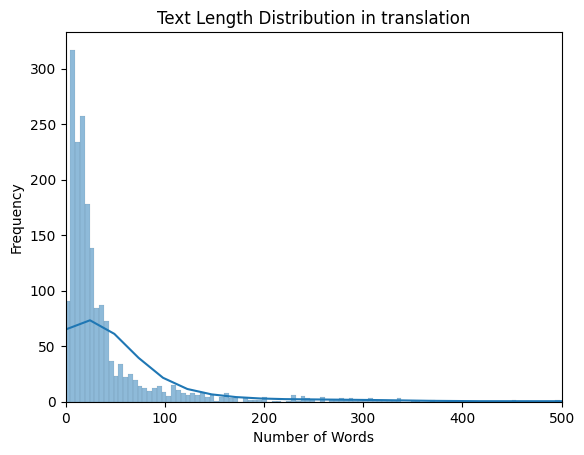

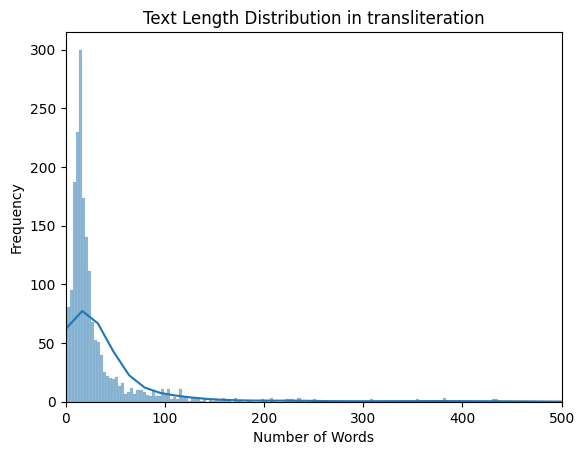

In [13]:
def text_length_analysis(df, column):
    df['text_length'] = df[column].apply(lambda x: len(x.split()))
    sns.histplot(df['text_length'], kde=True)
    plt.title(f'Text Length Distribution in {column}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.xlim(0, 500)
    plt.show()

text_length_analysis(df, 'translation')
text_length_analysis(df, 'transliteration')

### Character frequency analysis in transcriptions

We examine the frequency distribution of Sumerian characters using custom font rendering. First, we clean the glyph data to focus on Sumerian characters and generate a bar chart of the 20 most common characters, providing insights into the cuneiform script's character distribution.

In [15]:
# Clean sumTablets_train glyphs
def clean_glyphs(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[a-zA-Z]', '', text)  # Remove Latin characters
    return text.strip().lower()
df['glyphs'] = df['glyphs'].apply(clean_glyphs)
df

,id,glyphs,period,genre,transliteration,translation,text_length
0,P514378,𒐊𒋡𒁉𒐊𒋡𒃻𒐊𒂆𒋧 𒐈𒂆𒉌𒈫𒂆𒉀 𒌨𒀭𒎏𒆤 𒐊𒋡𒁉𒐊𒋡𒃻𒐊𒂆 𒐈𒂆𒉌𒈫𒂆𒉀 𒀀𒁕𒀀 𒐊𒋡𒁉𒐊...,Ur III,Administrative,5diš sila₃ kaš 5diš sila₃ ninda 5diš gin₂ šum₂...,5 sila3 beer 5 sila3 bread 5 shekels garlic 3 ...,157
1,P416427,𒇲𒉌𒁹𒈫𒋡𒂠𒊺 𒈗𒌫𒊏𒉌 𒌨𒄑𒇀𒌉𒀉𒀀𒋛𒇻 𒐈𒋡𒌨𒀭𒅗𒁲 𒐈𒋡𒈗𒀉𒍣𒁕𒌉𒀭𒀊𒌑𒊒 𒐈𒈦𒋡𒇽𒀭...,Ur III,Administrative,la₂ia₃1barig 2diš sila₃ dabin lugalur₂rani urg...,repaid arrears 1 barig 2 sila3 of dabinflour l...,41
2,P102320,𒁹𒄞𒊺 𒌓𒌋𒄰 𒆠𒀊𒁀𒊷𒂵𒋫 𒀀𒄷𒉿𒅕 𒉌𒆪 _ 𒌗𒂡𒀭𒈾 𒈬𒂗𒈤𒃲𒀭𒈾𒂗𒀭𒋀𒆠𒁀𒂠 𒁹,Ur III,Administrative,1diš gu₄ niga u₄ 1ukam ki abbasa₆gata ahuweer ...,1 ox grainfed 10th day from abbasaga aḫuwer ac...,17
3,P424401,𒁹𒂍𒆠 𒌗𒊑𒋫 𒁹𒈗𒍏𒁀𒀭 𒌗𒋗𒆰𒈾𒋫 𒁹𒄒𒆷 𒌗𒂍𒌗𒐋𒋫 𒊑𒊑𒂵 𒉺𒁀𒊷 𒁾𒉆𒊮𒌓 𒌨𒀀𒀭...,Ur III,Administrative,1diš e₂ki iti dalta 1diš lugalda₅baan iti šunu...,1 eki from the month flight 1 lugaldaban from ...,27
4,P131770,𒐉𒈦𒂆𒌋𒈫𒊺𒆬𒌓 𒋛𒉌𒌈 _ 𒐠𒐗𒄩𒊕𒉽 𒆬𒁉𒈫𒂆𒅆𒐋𒅅𒐋𒊺 𒐞𒐖𒄩𒊮𒁇 𒆬𒁉𒈫𒂆 𒐄𒄘𒋠 ...,Ur III,Administrative,4diš 12diš gin₂ 1u 2diš še ku₃babbar sii₃tum 3...,4 12 shekels 12 grains of silver the remaining...,232
...,...,...,...,...,...,...,...
1902,P320037,𒂷𒁾𒁀 𒁾𒁍𒁕 𒀀𒊒𒀀𒀭𒎏𒈥𒆠 𒄊𒇽𒄷𒉈𒊒𒆠 𒉌𒅅 _ 𒈬𒂗𒋼𒀊𒃲𒀭𒈹𒁀𒂠,Ur III,Administrative,pisan dubba dub gid₂da arua dninmarki giri₃ lu...,basketoftablets longtablets votive offerings o...,13
1903,P010890,𒐚𒎙𒋠𒈠𒈾 𒀕𒆠 𒐕𒐏𒋠𒈠𒈾 𒄑𒆵𒆠 𒐙𒋠𒈠𒈾 𒄘𒌍𒄑𒆕,Early Dynastic IIIa,Administrative,6geš₂ 2u siki mana unuki 1geš₂ 4u siki mana um...,30 onetalent stones weights with wooden pegs,17
1904,P416437,𒈫𒇻𒊺𒐉𒄰𒍑 𒈫𒇻𒊺𒀭𒈹 𒊮𒈗𒆠 𒈧 𒈗 𒊮𒋀𒀊𒆠𒈠 𒈫𒇻𒊺𒐈 𒈫𒇻𒊺𒀭𒂗𒆠 𒁹𒇻𒊺𒁾𒆷𒈤 ...,Ur III,Royal Inscription,2diš udu niga 4diškam us₂ 2diš udu niga dinann...,2 sheep barleyfed of 4th grade 2 sheep barleyf...,71
1905,P106830,𒌋𒐃𒊺𒄥𒈗 𒆠𒀜𒁕𒋫 𒊮𒋀𒀊𒆠𒈠 𒇽𒄭𒂵 𒋗𒁀𒋾 𒌗 _ 𒌋𒐃𒊺𒄥𒈗 _ 𒁕𒋫 𒇽𒄭𒂵𒋗𒁀𒋾...,Ur III,Administrative,1u 5aš še gur lugal ki addata ša₃ uri₅kima lu₂...,15 gur barley according to the kings gur from ...,29


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Cuneiform.
  fig.canvas.print_figure(bytes_io, **kw)
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Cuneiform.
  fig.canvas.print_figure(bytes_io, **kw)


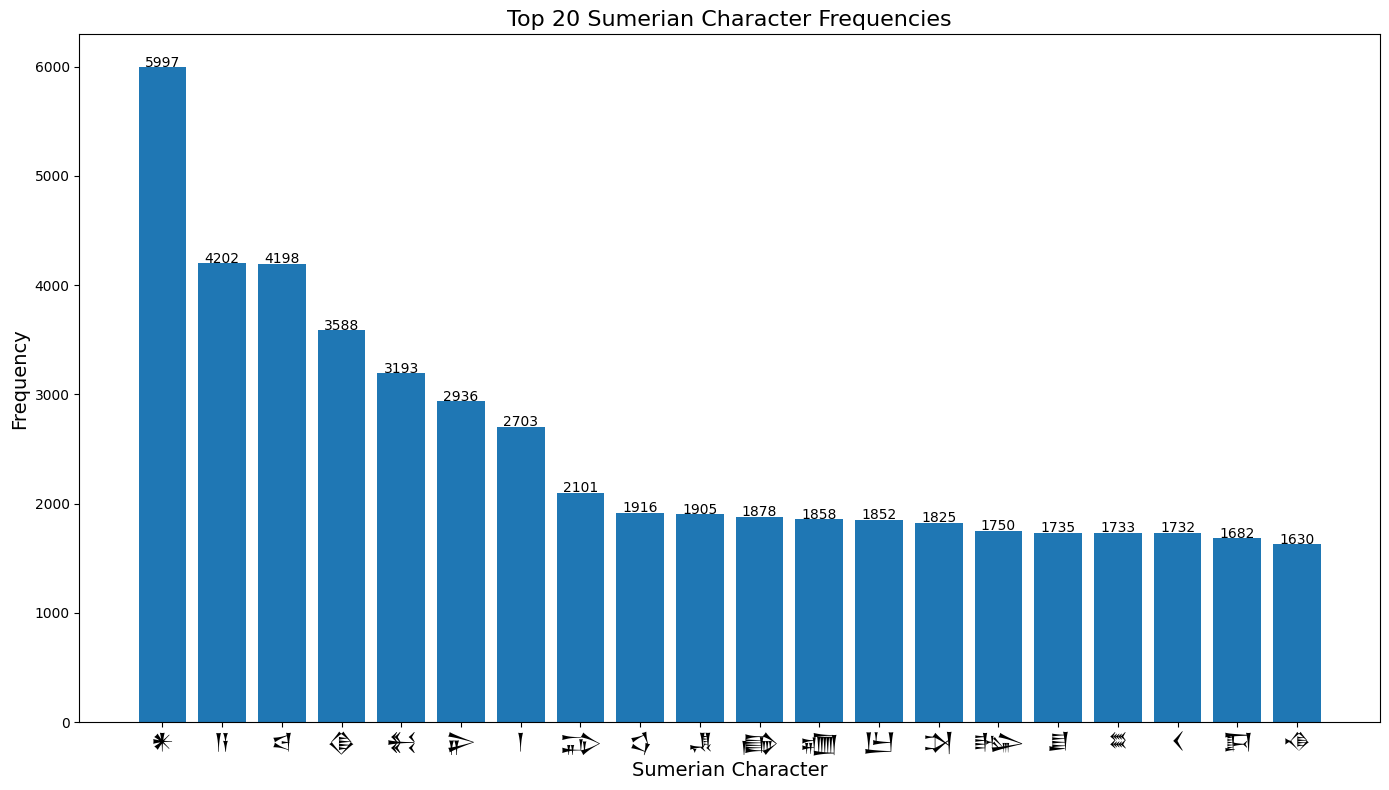

Top 20 Sumerian characters by frequency:


,Character,Frequency
11,𒀭,5997
14,𒀀,4202
82,𒁀,4198
74,𒆠,3588
79,𒈬,3193
7,𒉌,2936
16,𒁹,2703
2,𒁉,2101
45,𒌓,1916
81,𒂗,1905


In [18]:
def character_frequency_analysis(df, column, font_path='../fonts/SumerianFont.ttf'):
    import matplotlib.font_manager as fm
    import matplotlib as mpl
    
    # Register the custom font
    custom_font = fm.FontProperties(fname=font_path)
    
    # Save original font settings
    original_font_family = mpl.rcParams['font.family']
    
    # Get character frequencies
    all_text = ''.join(df[column].astype(str).tolist())
    char_counts = Counter([char for char in all_text if char != ' ' and char != ''])
    char_df = pd.DataFrame(char_counts.items(), columns=['Character', 'Frequency'])
    char_df = char_df.sort_values(by='Frequency', ascending=False)
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(char_df['Character'].head(20), char_df['Frequency'].head(20))
    
    # Configure the plot with default font for titles and labels (not Cuneiform)
    plt.title('Top 20 Sumerian Character Frequencies', fontsize=16)
    plt.xlabel('Sumerian Character', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    
    # Only use Cuneiform font for the x-tick labels (the actual Sumerian characters)
    plt.xticks(fontproperties=custom_font, fontsize=16, rotation=0)
    
    # Add frequency values above bars with default font
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{int(height)}', ha='center', fontsize=10)
    
    # Apply tight layout with warning suppression
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout()
    
    plt.show()
    
    # Restore original font settings
    mpl.rcParams['font.family'] = original_font_family
    
    return char_df

sumerian_font_path = '../fonts/NotoSansCuneiform-Regular.ttf'
char_df = character_frequency_analysis(df, 'glyphs', sumerian_font_path)

print("Top 20 Sumerian characters by frequency:")
display(char_df.head(20))

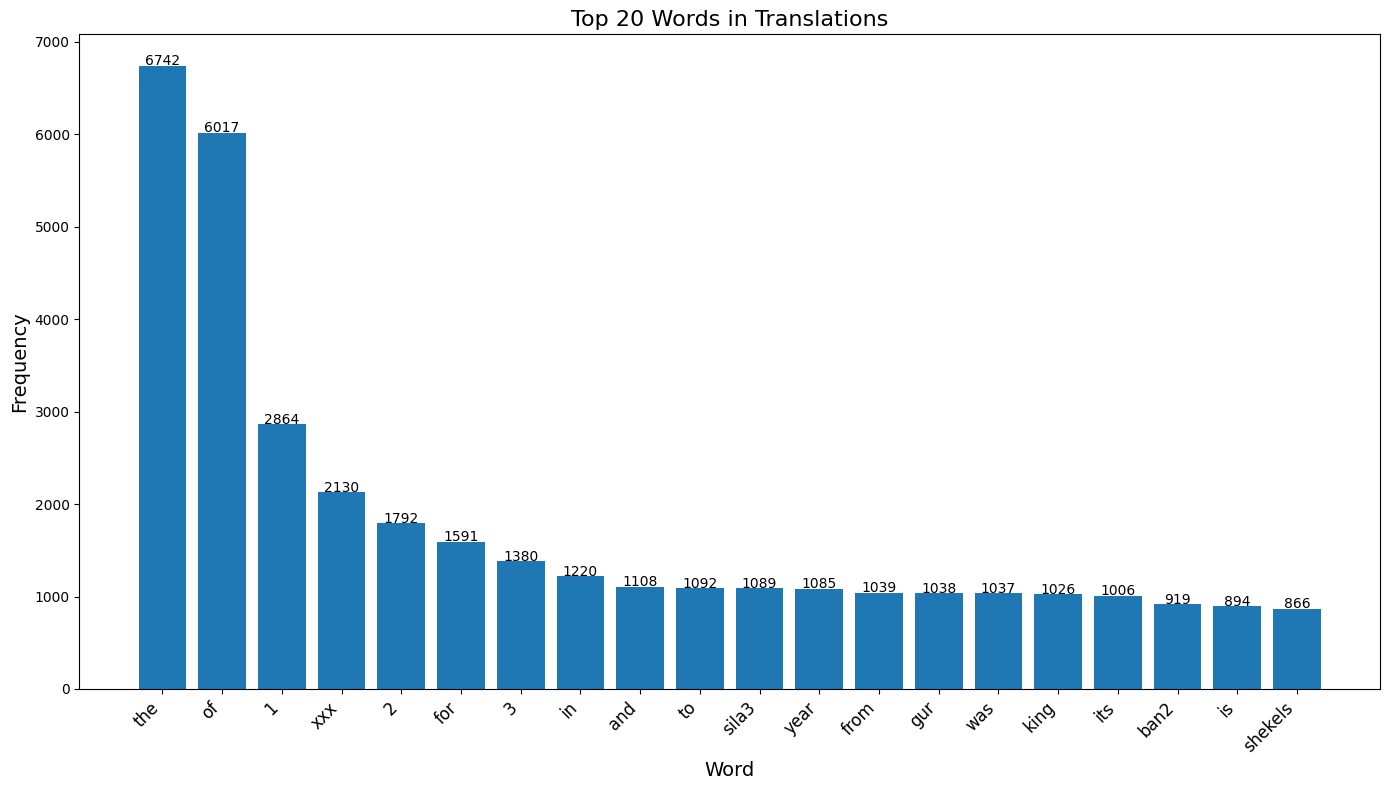

In [19]:
def word_frequency_analysis(df, column):
    all_text = ' '.join(df[column].astype(str).tolist())
    word_counts = Counter(all_text.split())
    word_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
    word_df = word_df.sort_values(by='Frequency', ascending=False)

    # Create the plot
    plt.figure(figsize=(14, 8))
    bars = plt.bar(word_df['Word'].head(20), word_df['Frequency'].head(20))
    plt.title('Top 20 Words in Translations', fontsize=16)
    plt.xlabel('Word', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{int(height)}', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

word_freq_df = word_frequency_analysis(df, 'translation')

Notice that there are many 'xxx' in the true translations: this is worth taking into acconut into our later evaluataion of translation models.

In [20]:
# filter translations containing the word 'xxx'
filtered = df[df['translation']
              .str.contains(r'\bxxx\b',  
                            case=False,  
                            na=False     
              )]
filtered['translation']

10        basketoftablets xxx xxx xxx xxx xxx xxx xxx xxx
13            basketoftablets xxx xxx xxx xxx xxx xxx xxx
21                    basketoftablets xxx xxx xxx xxx xxx
22      basketoftablets xxx xxx xxx xxx xxx xxx xxx xx...
24      basketoftablets reckoned accounts xxx of the h...
                              ...                        
1872                  basketoftablets xxx xxx xxx xxx xxx
1874      basketoftablets xxx xxx xxx xxx xxx xxx xxx xxx
1884                              basketoftablets xxx xxx
1895              basketoftablets xxx xxx xxx xxx xxx xxx
1896                          basketoftablets xxx xxx xxx
Name: translation, Length: 357, dtype: object

We can see these translation are pretty far-fetched. Hence, we filter them out of the dataframe.  

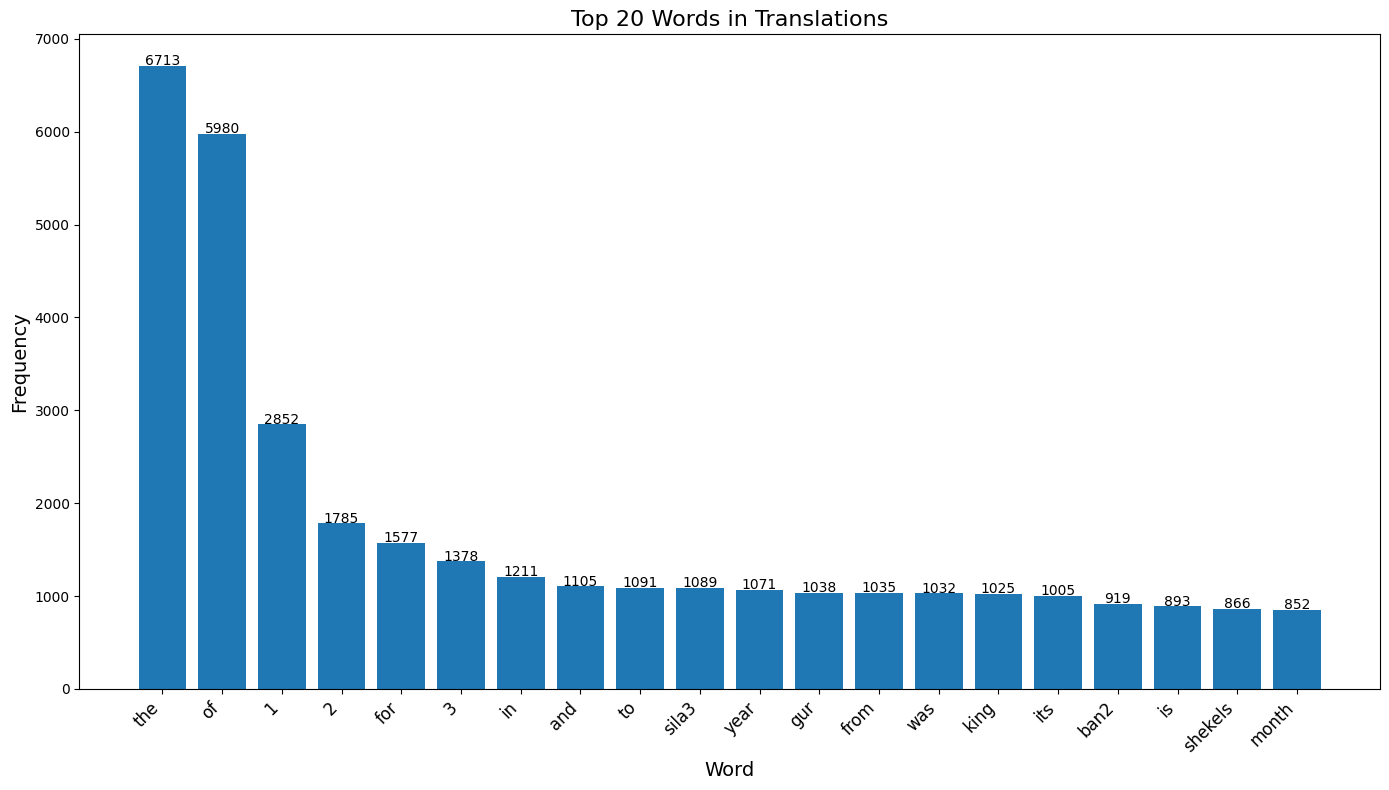

In [21]:
df_fil = df[~df['translation'].str.contains(r'\bxxx\b', case=False, na=False)]

df_fil
word_freq_df = word_frequency_analysis(df_fil, 'translation')

Little has changed, yet for future tasks it is surely beneficial to eliminate "corrupted" translations.

### Topic prevalence

Now we apply Latent Dirichlet Allocation (LDA) to identify 5 main topics in the corpus. We visualize the top 10 words for each topic, revealing themes related to agriculture, religious practices, administrative records, and daily life in ancient Mesopotamia.

/tmp/ipykernel_305113/532282475.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="rocket")


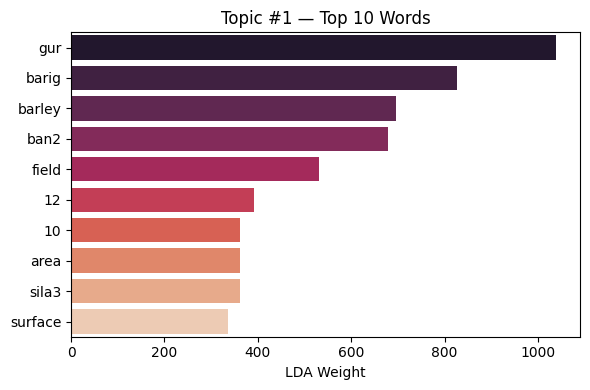

/tmp/ipykernel_305113/532282475.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="rocket")


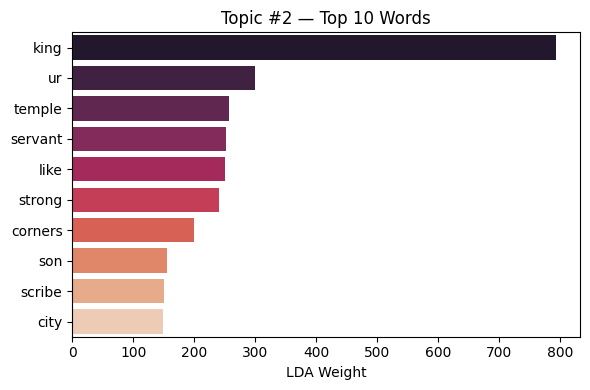

/tmp/ipykernel_305113/532282475.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="rocket")


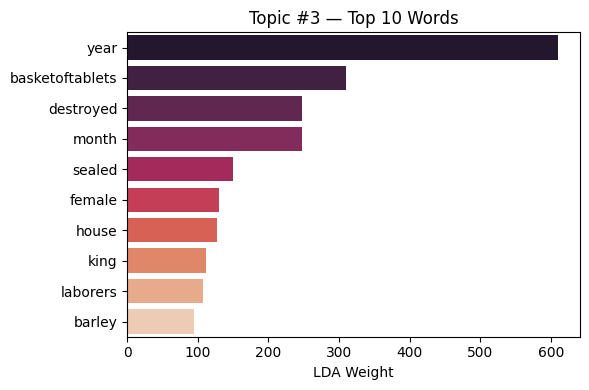

/tmp/ipykernel_305113/532282475.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="rocket")


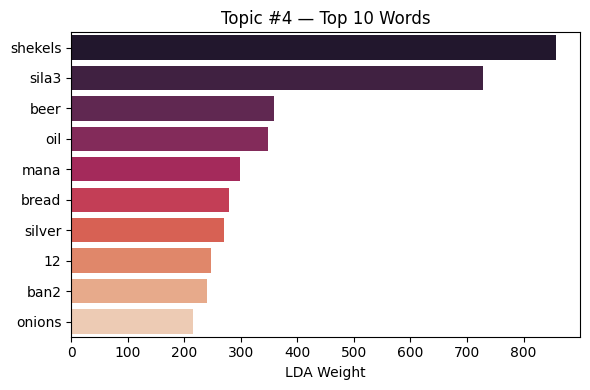

/tmp/ipykernel_305113/532282475.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, palette="rocket")


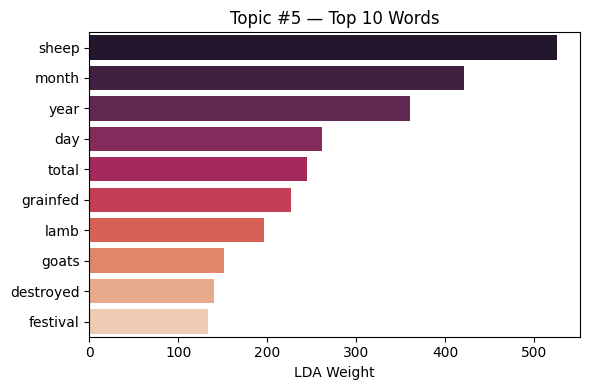

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Prepare the corpus. For instance, use the “translation” column (or the “transliteration” column) as input.
vectorizer = CountVectorizer(stop_words="english", max_df=0.8, min_df=5)
X = vectorizer.fit_transform(df_fil["translation"].astype(str))

# Fit an LDA (say, 5 topics)
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# For each topic, grab the top‐k words
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = feature_names[top_indices]
    top_weights = topic[top_indices]
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_weights, y=top_words, palette="rocket")
    plt.title(f"Topic #{topic_idx + 1} — Top {n_top_words} Words")
    plt.xlabel("LDA Weight")
    plt.tight_layout()
    plt.show()


### Linguistic Pattern Recognition

We also investigate linguistic patterns by:

- Comparing average word lengths between Sumerian and English (showing Sumerian words tend to be shorter)
- Identifying frequent bigrams (two-word sequences) in both languages The analysis reveals common phrases and word combinations that characterize Sumerian tablet content.

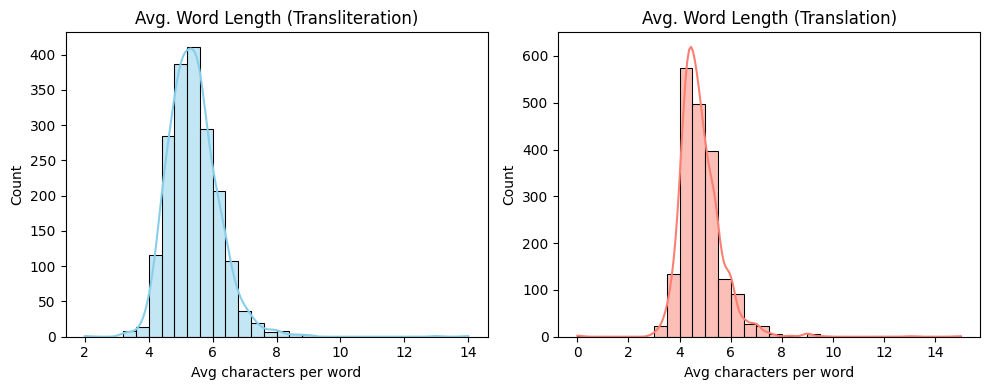

In [26]:
# Define a function to compute average word‐length per document
def avg_word_length(text: str):
    words = text.split()
    if len(words) == 0:
        return 0
    lengths = [len(w) for w in words]
    return sum(lengths) / len(lengths)

# Add new columns for avg word length in transliteration & translation
df["avg_len_translit"] = df["transliteration"].fillna("").apply(avg_word_length)
df["avg_len_trans"] = df["translation"].fillna("").apply(avg_word_length)

# Plot histograms side by side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df["avg_len_translit"], bins=30, kde=True, color="skyblue")
plt.title("Avg. Word Length (Transliteration)")
plt.xlabel("Avg characters per word")

plt.subplot(1, 2, 2)
sns.histplot(df["avg_len_trans"], bins=30, kde=True, color="salmon")
plt.title("Avg. Word Length (Translation)")
plt.xlabel("Avg characters per word")

plt.tight_layout()
plt.show()

/tmp/ipykernel_305113/2284654617.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_bigrams, palette="viridis")


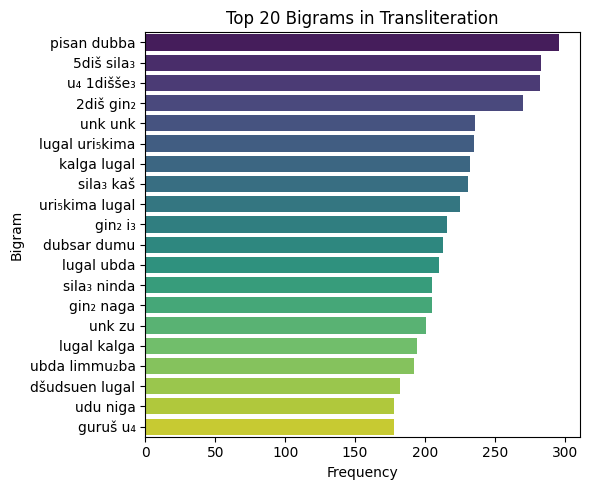

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=5, stop_words="english")
X_bi = bigram_vectorizer.fit_transform(df_fil["transliteration"].astype(str))
sum_bi = X_bi.sum(axis=0).A1  # total counts for each bigram
bigrams = bigram_vectorizer.get_feature_names_out()

# 20 most frequent bigrams
top_n = 20
top_idx = sum_bi.argsort()[::-1][:top_n]
top_bigrams = [bigrams[i] for i in top_idx]
top_counts = sum_bi[top_idx]

plt.figure(figsize=(6, 5))
sns.barplot(x=top_counts, y=top_bigrams, palette="viridis")
plt.title("Top 20 Bigrams in Transliteration")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()

/tmp/ipykernel_305113/3624930638.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts_trans, y=top_bigrams_trans, palette="viridis")


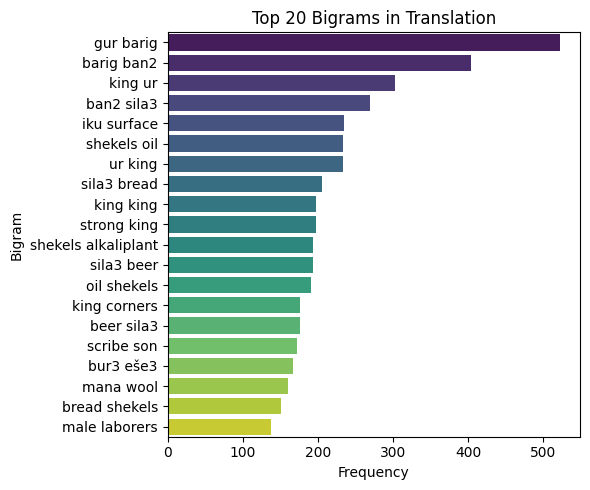

In [28]:
# Build a bigram‐only CountVectorizer on the translation column
bigram_vectorizer_trans = CountVectorizer(
    ngram_range=(2, 2),
    min_df=5,
    stop_words="english"   
)

X_bi_trans = bigram_vectorizer_trans.fit_transform(df_fil["translation"].fillna("").astype(str))

# Sum up counts for each bigram across all documents
sum_bi_trans = X_bi_trans.sum(axis=0).A1
bigrams_trans = bigram_vectorizer_trans.get_feature_names_out()

# Pick the top 20 most frequent bigrams
top_n = 20
top_idx_trans = sum_bi_trans.argsort()[::-1][:top_n]
top_bigrams_trans = [bigrams_trans[i] for i in top_idx_trans]
top_counts_trans = sum_bi_trans[top_idx_trans]

# Plot a horizontal bar chart of the top 20 bigrams (translation)
plt.figure(figsize=(6, 5))
sns.barplot(x=top_counts_trans, y=top_bigrams_trans, palette="viridis")
plt.title("Top 20 Bigrams in Translation")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()


### Translation Quality Assessment

We evaluate translation quality by:
- Comparing token counts between source and target texts (showing a roughly linear relationship)
- Computing type-token ratios (lexical diversity measure)
- Examining correlations across different genres and historical periods

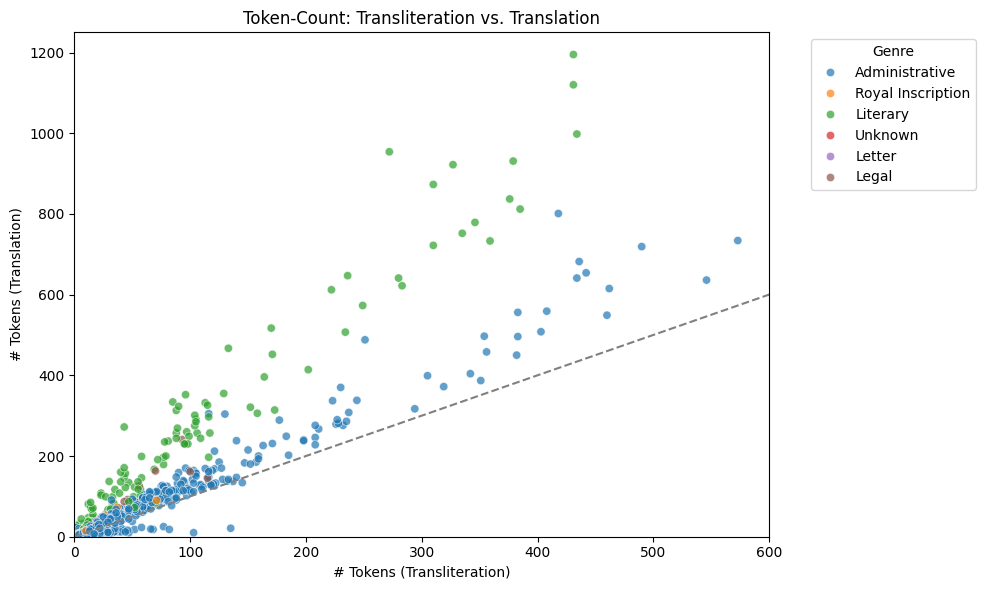

In [29]:
# Compute token‐counts
df["tokens_translit"] = df["transliteration"].fillna("").apply(lambda t: len(t.split()))
df["tokens_trans"] = df["translation"].fillna("").apply(lambda t: len(t.split()))

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="tokens_translit",
    y="tokens_trans",
    data=df,
    hue="genre",     
    palette="tab10",
    alpha=0.7,
)
plt.plot([0, df[["tokens_translit", "tokens_trans"]].max().max()],
         [0, df[["tokens_translit", "tokens_trans"]].max().max()],
         ls="--", c="gray")
plt.title("Token‐Count: Transliteration vs. Translation")
plt.xlabel("# Tokens (Transliteration)")
plt.ylabel("# Tokens (Translation)")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.xlim(0, 600)
plt.ylim(0, 1250)
plt.show()


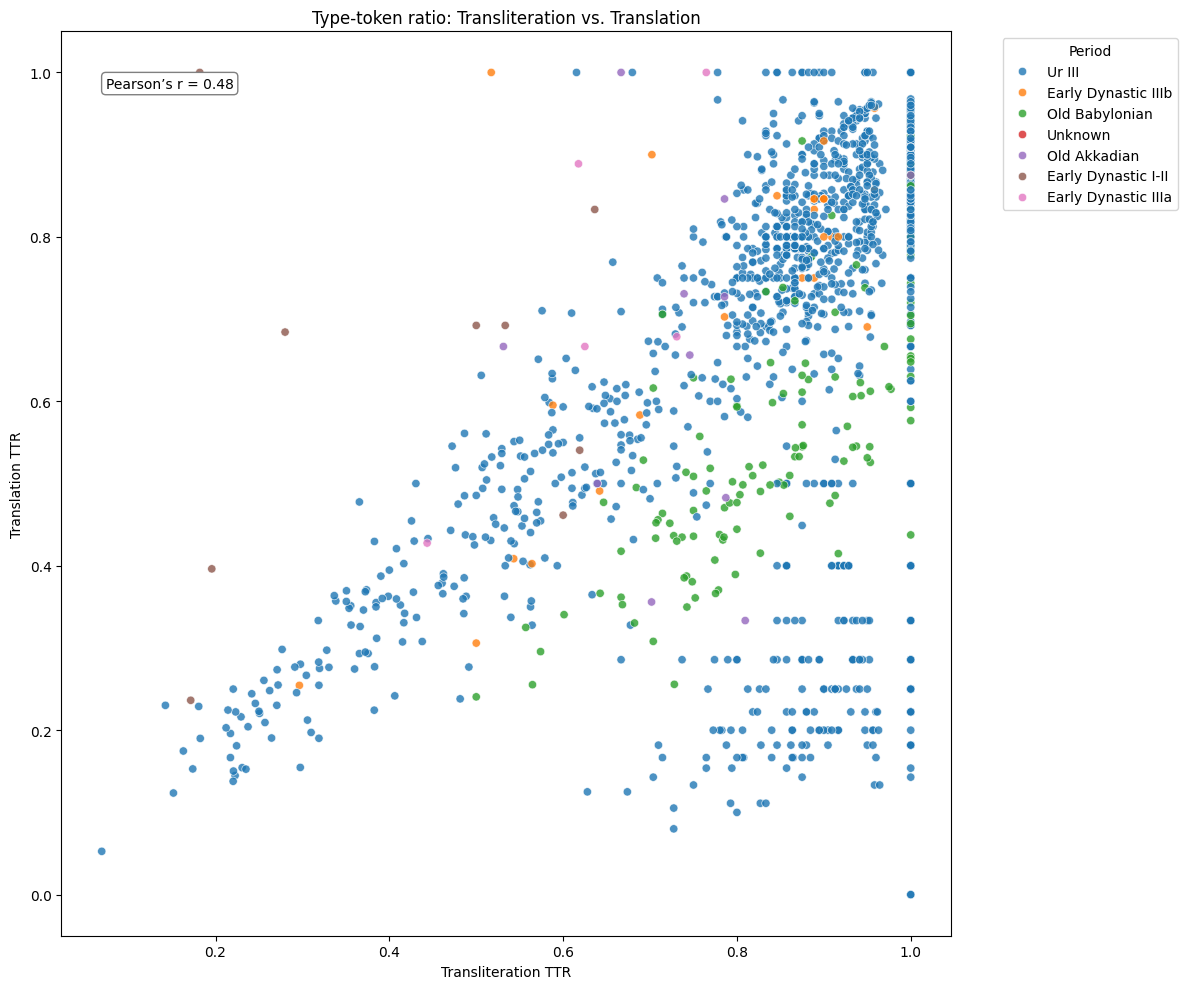

In [31]:
def type_token_ratio(text: str):
    words = text.split()
    n_tokens = len(words)
    if n_tokens == 0:
        return 0
    n_types = len(set(words))
    return n_types / n_tokens

# Compute TTR for transliteration and translation
df["ttr_translit"] = df["transliteration"].fillna("").apply(type_token_ratio)
df["ttr_trans"] = df["translation"].fillna("").apply(type_token_ratio)

# Scatterplot & Pearson correlation
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="ttr_translit",
    y="ttr_trans",
    data=df,
    hue="period",
    palette="tab10",
    alpha=0.8,
)
plt.title("Type-token ratio: Transliteration vs. Translation")
plt.xlabel("Transliteration TTR")
plt.ylabel("Translation TTR")

# Compute and annotate Pearson's r on the plot
r = df[["ttr_translit", "ttr_trans"]].dropna().corr().iloc[0, 1]
plt.text(
    0.05,
    0.95,
    f"Pearson’s r = {r:.2f}",
    transform=plt.gca().transAxes,
    ha="left",
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"),
)

plt.legend(title="Period", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Total and per-type token counts, over each single period, are mapped linearly from transliteration to translation, assessing the good quality of the latter.